# Plasticity

This example is taken from
[Ferrite.jl's plasticity example](https://ferrite-fem.github.io/Ferrite.jl/stable/examples/plasticity/)
and shows how `FESolvers` can be used to solve this nonlinear problem with time dependent loading.


First we need to load all required packages

In [1]:
using FESolvers, Ferrite, Tensors, SparseArrays, LinearAlgebra, Plots

We first include some basic definitions taken and modified from the original
[example](https://ferrite-fem.github.io/Ferrite.jl/stable/examples/plasticity/).
These definitions are available here: [plasticity_definitions.jl](plasticity_definitions.jl)

In [2]:
include("plasticity_definitions.jl");

## Problem definition
We divide the problem struct into three parts: definitions (`def`), a buffer (`buf`), and
postprocessing (`post`) to structure the information and make it easier to save the simulation
settings (enough to save `def` as the others will be created based on this one)

In [3]:
struct PlasticityProblem{PD,PB,PP}
    def::PD
    buf::PB
    post::PP
end

`PlasticityModel` is our `def` and contain all problem settings (mesh, material, loads, interpolations, etc.)

In [4]:
struct PlasticityModel
    grid
    interpolation
    dh
    material
    traction_rate
    dbcs
end

function PlasticityModel()
    E = 200.0e9
    H = E/20
    ν = 0.3
    σ₀ = 200e6
    material = J2Plasticity(E, ν, σ₀, H)

    L = 10.0
    w = 1.0
    h = 1.0

    traction_rate = 1.e7    # N/s

    n = 2
    nels = (10n, n, 2n)
    P1 = Vec((0.0, 0.0, 0.0))
    P2 = Vec((L, w, h))
    grid = generate_grid(Tetrahedron, nels, P1, P2)
    interpolation = Lagrange{3, RefTetrahedron, 1}()
    dh = create_dofhandler(grid, interpolation)
    dbcs = create_bc(dh, grid)
    return PlasticityModel(grid,interpolation,dh,material,traction_rate,dbcs)
end;

`PlasticityFEBuffer` is our `buf` and contain all problem arrays and other allocated values

In [5]:
struct PlasticityFEBuffer
    cellvalues
    facevalues
    K
    r
    u
    states
    states_old
    time::Vector # length(time)=1, could use ScalarBuffer instead
end

function build_febuffer(model::PlasticityModel)
    dh = model.dh
    n_dofs = ndofs(dh)
    cellvalues, facevalues = create_values(model.interpolation)
    u  = zeros(n_dofs)
    r = zeros(n_dofs)
    K = create_sparsity_pattern(dh)
    nqp = getnquadpoints(cellvalues)
    states = [J2PlasticityMaterialState() for _ in 1:nqp, _ in 1:getncells(model.grid)]
    states_old = [J2PlasticityMaterialState() for _ in 1:nqp, _ in 1:getncells(model.grid)]
    return PlasticityFEBuffer(cellvalues,facevalues,K,r,u,states,states_old,[0.0])
end;

Finally, we define our `post` that contains variables that we will save during the simulation

In [6]:
struct PlasticityPost{T}
    umax::Vector{T}
    tmag::Vector{T}
end
PlasticityPost() = PlasticityPost(Float64[],Float64[]);

To facilitate reuse, we define a function that gives our full problem struct
based on the problem definition

In [7]:
build_problem(def::PlasticityModel) = PlasticityProblem(def, build_febuffer(def), PlasticityPost());

## Neumann boundary conditions
We then define a separate function for the Neumann boundary conditions
(note that this difference to the original example is not required,
but only to separate the element assembly and external boundary conditions)

In [8]:
function apply_neumann!(model::PlasticityModel,buffer::PlasticityFEBuffer)
    t = buffer.time[1]
    nu = getnbasefunctions(buffer.cellvalues)
    re = zeros(nu)
    facevalues = buffer.facevalues
    grid = model.grid
    traction = Vec((0.0, 0.0, model.traction_rate*t))

    for (i, cell) in enumerate(CellIterator(model.dh))
        fill!(re, 0)
        eldofs = celldofs(cell)
        for face in 1:nfaces(cell)
            if onboundary(cell, face) && (cellid(cell), face) ∈ getfaceset(grid, "right")
                reinit!(facevalues, cell, face)
                for q_point in 1:getnquadpoints(facevalues)
                    dΓ = getdetJdV(facevalues, q_point)
                    for i in 1:nu
                        δu = shape_value(facevalues, q_point, i)
                        re[i] -= (δu ⋅ traction) * dΓ
                    end
                end
            end
        end
        buffer.r[eldofs] .+= re
    end
end;

## Specialized functions for our problem
We first define our "get"-functions to get the key arrays for our problem.
Note that these functions don't calculate or update anything, that updating
is taken care of by `update-update_to_next_step!` and `update_problem!` below.

In [9]:
FESolvers.getunknowns(p::PlasticityProblem) = p.buf.u;
FESolvers.getresidual(p::PlasticityProblem) = p.buf.r;
FESolvers.getjacobian(p::PlasticityProblem) = p.buf.K;

We then define the function to update the problem to a different time. This
is typically used to set time dependent boundary conditions. Here, it is also
possible to make an improved guess for the solution to this time step if desired.

In [10]:
function FESolvers.update_to_next_step!(p::PlasticityProblem, time)
    p.buf.time .= time
end;

Next, we define the updating of the problem given a new guess to the solution.
Note that we use `Δu=nothing` for the case it is not given, to signal no change.
This version is called directly after update_to_next_step! before entering
the nonlinear iterations.

In [11]:
function FESolvers.update_problem!(p::PlasticityProblem, Δu=nothing)
    buf = p.buf
    def = p.def
    if !isnothing(Δu)
        apply_zero!(Δu, p.def.dbcs)
        buf.u .+= Δu
    end
    doassemble!(buf.cellvalues, buf.facevalues, buf.K, buf.r,
                def.grid, def.dh, def.material, buf.u, buf.states, buf.states_old)
    apply_neumann!(def,buf)
    apply_zero!(buf.K, buf.r, def.dbcs)
end;

In this example, we use the standard convergence criterion that the norm of the free
degrees of freedom is less than the iteration tolerance.

In [12]:
FESolvers.calculate_convergence_measure(p::PlasticityProblem) = norm(FESolvers.getresidual(p)[free_dofs(p.def.dbcs)]);

After convergence, we need to update the state variables.

In [13]:
function FESolvers.handle_converged!(p::PlasticityProblem)
    p.buf.states_old .= p.buf.states
end;

As postprocessing, which is called after `handle_converged!`, we save
the maximum displacement as well as the traction magnitude.

In [14]:
function FESolvers.postprocess!(p::PlasticityProblem, step)
    push!(p.post.umax, maximum(abs, FESolvers.getunknowns(p)))
    push!(p.post.tmag, p.def.traction_rate*p.buf.time[1])
end;

## Solving the problem
First, we define a helper function to plot the results after the solution

In [15]:
function plot_results(problem::PlasticityProblem; plt=plot(), label=nothing, markershape=:auto, markersize=4)
    umax = vcat(0.0, problem.post.umax)
    tmag = vcat(0.0, problem.post.tmag)
    plot!(plt, umax, tmag, linewidth=0.5, title="Traction-displacement", label=label,
        markeralpha=0.75, markershape=markershape, markersize=markersize)
    ylabel!(plt, "Traction [Pa]")
    xlabel!(plt, "Maximum deflection [m]")
    return plt
end;

Finally, we can solve the problem with different time stepping strategies and plot the results

[1.0]


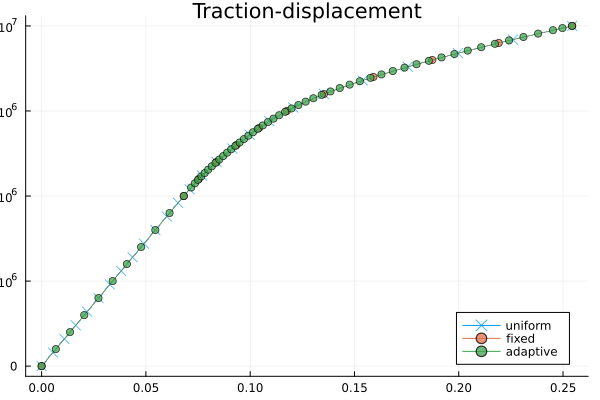

In [16]:
function example_solution()
    def = PlasticityModel()

    # Fixed uniform time steps
    problem = build_problem(def)
    solver = QuasiStaticSolver(NewtonSolver(;tolerance=1.0), FixedTimeStepper(;num_steps=25,Δt=0.04))
    solve_problem!(solver, problem)
    plt = plot_results(problem, label="uniform", markershape=:x, markersize=5)

    # Same time steps as Ferrite example
    problem = build_problem(def)
    solver = QuasiStaticSolver(NewtonSolver(;tolerance=1.0), FixedTimeStepper(append!([0.], collect(0.5:0.05:1.0))))
    solve_problem!(solver, problem)
    plot_results(problem, plt=plt, label="fixed", markershape=:circle)

    # Adaptive time stepping
    problem = build_problem(def)
    ts = AdaptiveTimeStepper(0.05, 1.0; Δt_min=0.01, Δt_max=0.2)
    solver = QuasiStaticSolver(NewtonSolver(;tolerance=1.0, maxiter=4), ts)
    solve_problem!(solver, problem)
    println(problem.buf.time)
    plot_results(problem, plt=plt, label="adaptive", markershape=:circle)
    plot!(;legend=:bottomright)
end;

example_solution()

Which gives the following result
![](plasticity.svg)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*